## Imports & setup

In [ ]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv
from keras import ops
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
keras.utils.set_random_seed(42)

## Load the CIFAR10 dataset

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Total training examples: 50000
Total test examples: 10000


## Define hyperparameters

In [14]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 3
IMAGE_SIZE = 72

## Initialize `RandAugment` object

Now, we will initialize a `RandAugment` object from the `imgaug.augmenters` module with
the parameters suggested by the RandAugment authors.

In [5]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.8
)

## Create TensorFlow `Dataset` objects

In [6]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (rand_augment(tf.cast(x, tf.uint8)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

## Visualize the dataset augmented with RandAugment

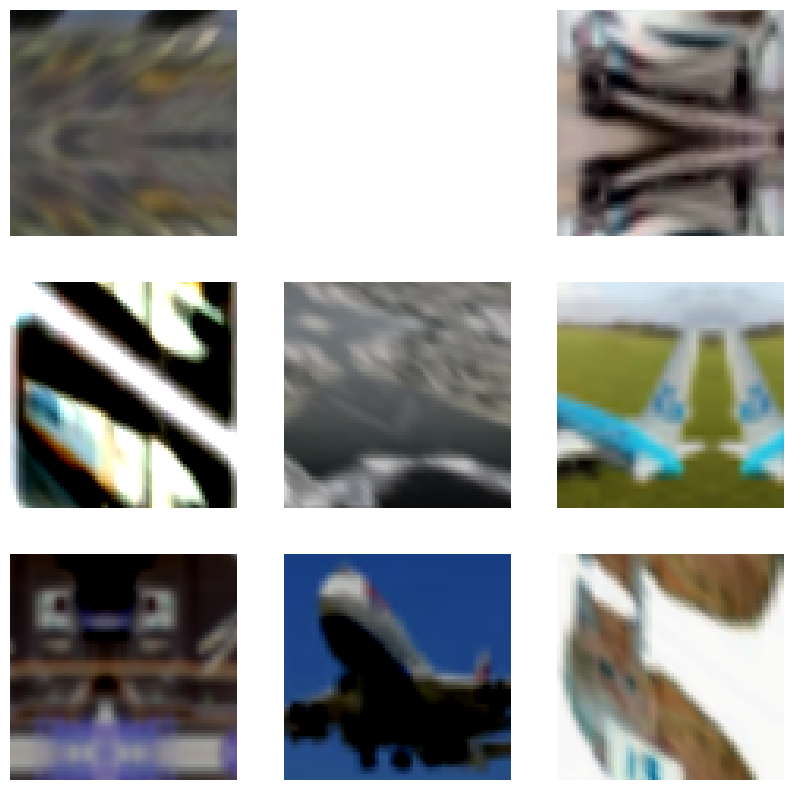

In [20]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

You are encouraged to run the above code block a couple of times to see different
variations.

In [10]:
def get_training_model():
    resnet50_v2 = keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model


get_training_model().summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 72, 72, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 10)                  │      23,585,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 23,539,850 (89.80 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [11]:
initial_model = get_training_model()
initial_model.save_weights("initial.weights.h5")

## Train model with RandAugment

In [15]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial.weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
history = rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 325s 704ms/step - accuracy: 0.1652 - loss: 2.3592 - val_accuracy: 0.3000 - val_loss: 1.9328
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 280s 645ms/step - accuracy: 0.2484 - loss: 2.0570 - val_accuracy: 0.3753 - val_loss: 1.8068
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 265s 653ms/step - accuracy: 0.2837 - loss: 1.9741 - val_accuracy: 0.3975 - val_loss: 2.1005
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.4014 - loss: 2.0853
Test accuracy: 39.75%
